<a href="https://colab.research.google.com/github/Dogolaa/ArtificialIntelligence/blob/main/Trabalho_Final_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Atividade 3

Lucas Dogo de Souza Pezzuto - 2020.1.08.026

Matheus Malvão Barbosa - 2020.1.08.025

### Introdução ao Projeto
Este notebook foca na comparação de três técnicas de aprendizado de máquina para classificar casos de diabetes. As técnicas utilizadas são Regressão Logística, Árvores de Decisão e Random Forest.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import ParameterGrid
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### Carregamento e Preparação dos Dados
Os dados são carregados e as características necessárias são extraídas. Também realizamos a conversão dos rótulos para formatos binários para facilitar o processamento.


In [ ]:
# Caminho do arquivo CSV contendo a base de dados
data_path = "/content/drive/My Drive/IA/diabetes.csv"
df = pd.read_csv(data_path)
# Verificação das primeiras linhas para confirmar o carregamento correto
print(df.head())
print(df.columns)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


### Separando a Base de Dados

Nesta seção, dividimos a base de dados em conjuntos de treinamento e teste. A separação é crucial para evitar o overfitting e para avaliar o desempenho dos modelos de forma mais objetiva e imparcial em dados não vistos durante o treinamento.

- **Conjunto de Treinamento (70% dos dados):** Usado para treinar os modelos. Contém a maior parte dos dados para permitir que os modelos aprendam de forma eficaz.
- **Conjunto de Teste (30% dos dados):** Usado para testar a precisão dos modelos após o treinamento. Ajuda a entender como o modelo se comportará com novos dados.

A divisão dos dados utiliza um `RANDOM_STATE` para garantir a reprodutibilidade dos resultados, permitindo que a mesma divisão seja reproduzida em futuras execuções.

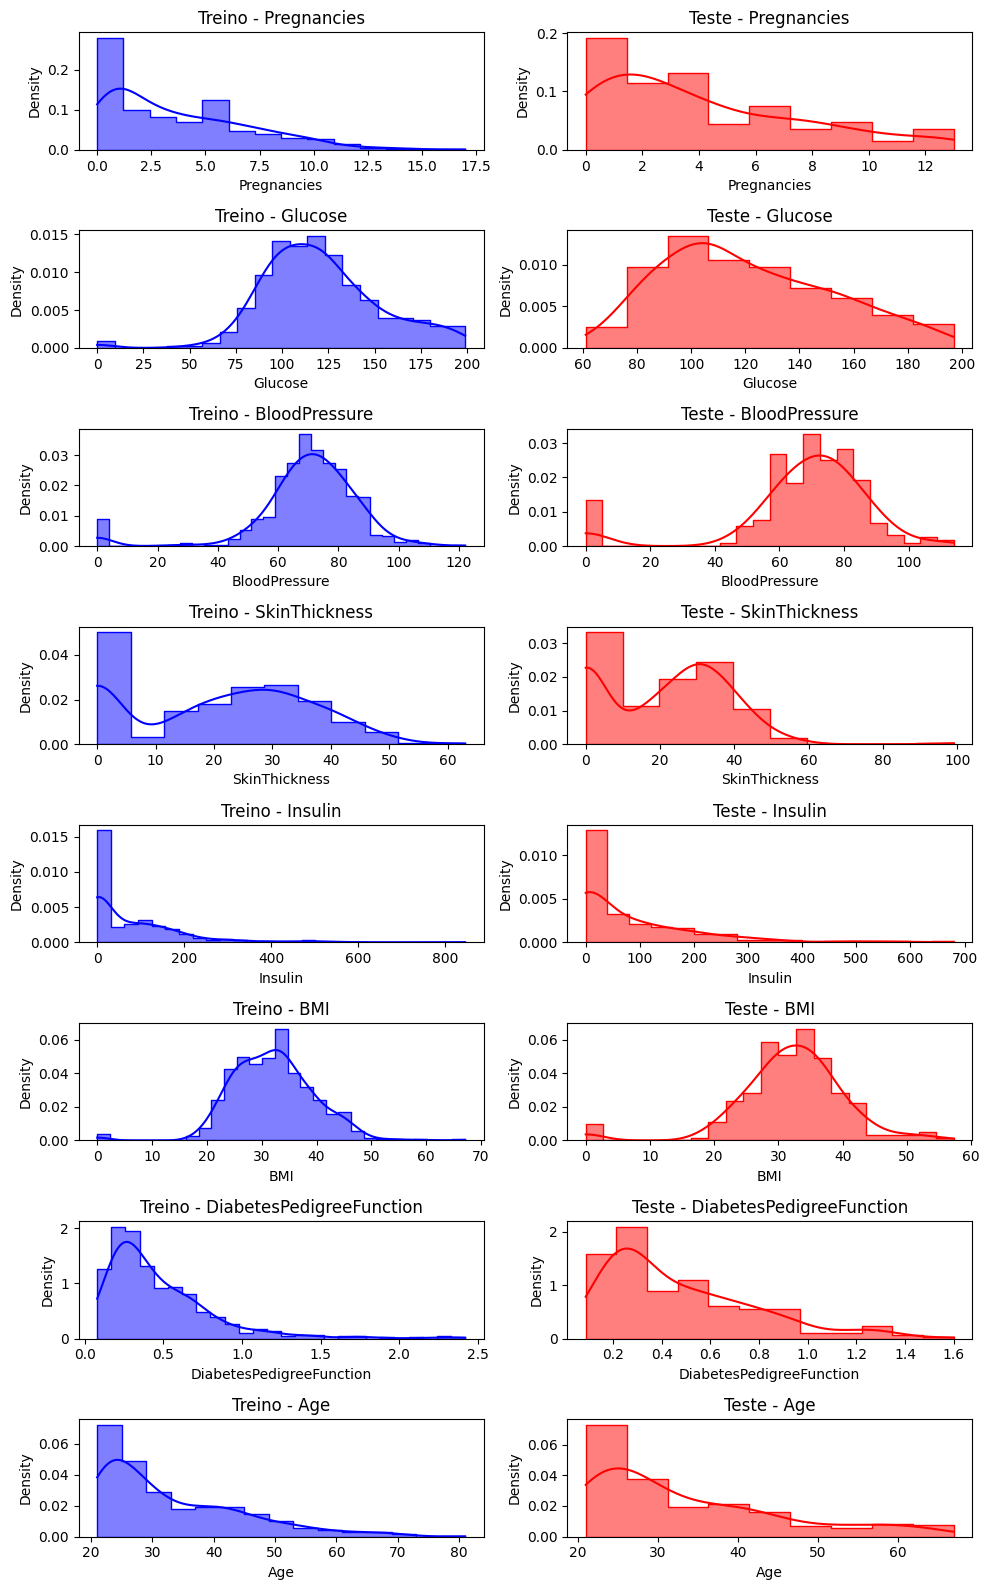

In [ ]:
# Configurações de divisão do dataset
TRAIN_SIZE = 0.7
TEST_SIZE = 0.3
RANDOM_STATE = 42

# Colunas de características e rótulo
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
X = df[feature_columns]
y = df['Outcome']  # Assumindo que os rótulos já são 0 e 1

# Divisão do dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Função para plotar a distribuição das características nos conjuntos de treino e teste
def plot_data_distribution(X_train, X_test, features):
    fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(10, 2 * len(features)))  # Ajustado para uma largura menor
    for i, feature in enumerate(features):
        sns.histplot(X_train[feature], ax=axes[i, 0], color='blue', kde=True, element='step', stat="density", common_norm=False)
        axes[i, 0].set_title(f'Treino - {feature}')
        sns.histplot(X_test[feature], ax=axes[i, 1], color='red', kde=True, element='step', stat="density", common_norm=False)
        axes[i, 1].set_title(f'Teste - {feature}')
    plt.tight_layout()
    plt.show()

# Chamada da função para plotar a distribuição das características
plot_data_distribution(X_train, X_test, feature_columns)

### Visualizando a Distribuição do Rótulo 'Outcome'

A distribuição do rótulo `'outcome'` nos conjuntos de treino e teste é crucial para entender o equilíbrio entre as classes. Essa visualização nos ajuda a verificar se as classes estão balanceadas ou se existe algum viés que poderia afetar o desempenho dos modelos.

- **Gráfico à esquerda:** Mostra a distribuição dos rótulos no conjunto de treinamento.
- **Gráfico à direita:** Mostra a distribuição dos rótulos no conjunto de teste.

Ambos os gráficos são fundamentais para assegurar que ambos os conjuntos refletem proporções semelhantes de casos, evitando assim que o modelo seja treinado ou testado de maneira tendenciosa.


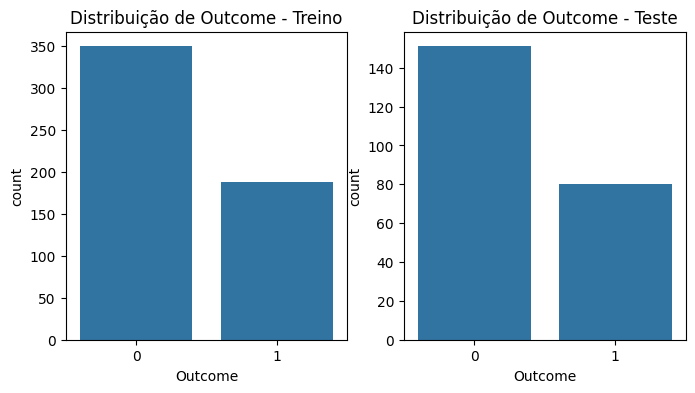

In [ ]:
# Visualizando a distribuição do rótulo 'Outcome'
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # Ajustado para uma largura total menor
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title('Distribuição de Outcome - Treino')
sns.countplot(x=y_test, ax=ax[1])
ax[1].set_title('Distribuição de Outcome - Teste')
plt.show()

### Função para Treinar e Avaliar Modelos

Nesta seção, definimos uma função que é responsável por treinar e avaliar os modelos de aprendizado de máquina. A função recebe como parâmetros o modelo a ser treinado, os conjuntos de dados de treinamento e teste, e o número de repetições desejadas para a avaliação do modelo. A função realiza os seguintes passos:

1. **Treinamento do Modelo**: O modelo é treinado usando os dados de treinamento fornecidos.
2. **Predição e Avaliação**: Após o treinamento, o modelo é usado para fazer previsões no conjunto de teste. A acurácia dessas previsões é calculada para avaliar o desempenho do modelo.
3. **Validação Cruzada**: Para garantir que a avaliação seja robusta, utilizamos a validação cruzada, que repete o processo de divisão dos dados de treinamento em subconjuntos, treina o modelo em cada subconjunto e valida em outro conjunto. A média dos resultados da validação cruzada é calculada para fornecer uma medida confiável do desempenho do modelo.
4. **Repetições**: O processo de treinamento e avaliação pode ser repetido várias vezes para garantir a consistência dos resultados.

A função retorna os parâmetros utilizados, a acurácia média e a pontuação média da validação cruzada para cada configuração de parâmetros testada. Isso nos permite comparar diferentes configurações e escolher a melhor para nosso modelo.


In [ ]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    return model, accuracy, np.mean(cv_scores)

### Árvore de Decisão
A Árvore de Decisão é um modelo simples e interpretável, usado frequentemente para tarefas de classificação. Aqui, treinamos o modelo com o conjunto de treino e avaliamos sua acurácia e validação cruzada. Adicionalmente, visualizamos a árvore para entender como as decisões estão sendo tomadas.


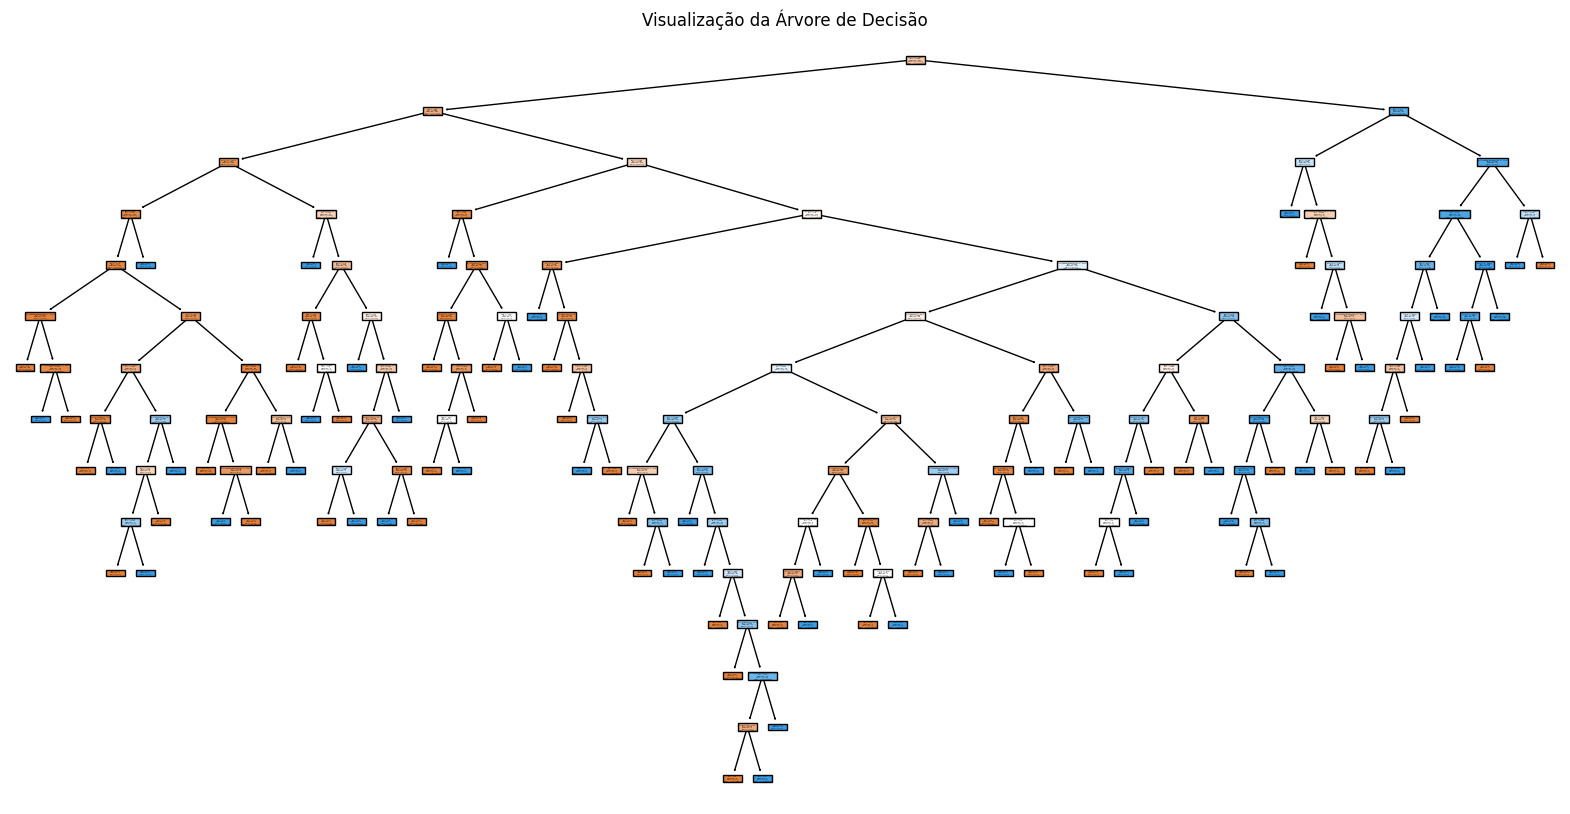

In [ ]:
decision_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_model, dt_accuracy, dt_cv_score = train_and_evaluate(decision_tree_model, X_train, X_test, y_train, y_test)
plt.figure(figsize=(20,10))
plot_tree(dt_model, filled=True, feature_names=feature_columns, class_names=['Sem Diabetes', 'Com Diabetes'])
plt.title('Visualização da Árvore de Decisão')
plt.show()


In [ ]:
print(f"Árvore de Decisão - Acurácia: {dt_accuracy:.2f}, CV Score: {dt_cv_score:.2f}")

Árvore de Decisão - Acurácia: 0.70, CV Score: 0.70


### Regressão Logística
A Regressão Logística é amplamente utilizada para problemas de classificação binária. Nesta seção, treinamos o modelo de Regressão Logística, calculamos sua acurácia e validação cruzada, e visualizamos os coeficientes para entender a influência de cada característica na decisão.


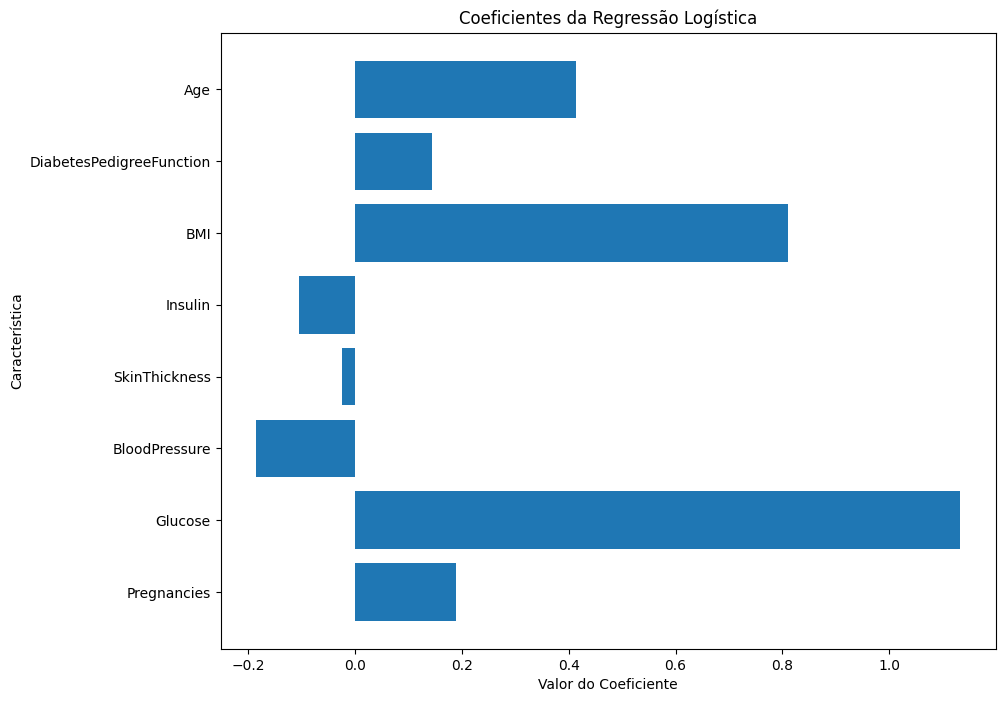

In [ ]:
# Definindo o modelo de Regressão Logística com mais iterações
logistic_regression_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))

# Treinando e avaliando o modelo
lr_model, lr_accuracy, lr_cv_score = train_and_evaluate(logistic_regression_model, X_train, X_test, y_train, y_test)

# Extraindo o modelo de Regressão Logística da pipeline para obter os coeficientes
logistic_regression = lr_model.named_steps['logisticregression']

# Visualizando os coeficientes das características
plt.figure(figsize=(10, 8))
plt.barh(feature_columns, logistic_regression.coef_[0])
plt.xlabel("Valor do Coeficiente")
plt.ylabel("Característica")
plt.title("Coeficientes da Regressão Logística")
plt.show()

In [ ]:
print(f"Regressão Logística - Acurácia: {lr_accuracy:.2f}, CV Score: {lr_cv_score:.2f}")

Regressão Logística - Acurácia: 0.74, CV Score: 0.78


### Random Forest
Random Forest é um método de ensemble que usa múltiplas árvores de decisão para melhorar a precisão da classificação. Avaliamos sua performance através de acurácia e validação cruzada e visualizamos a importância das características para o modelo.


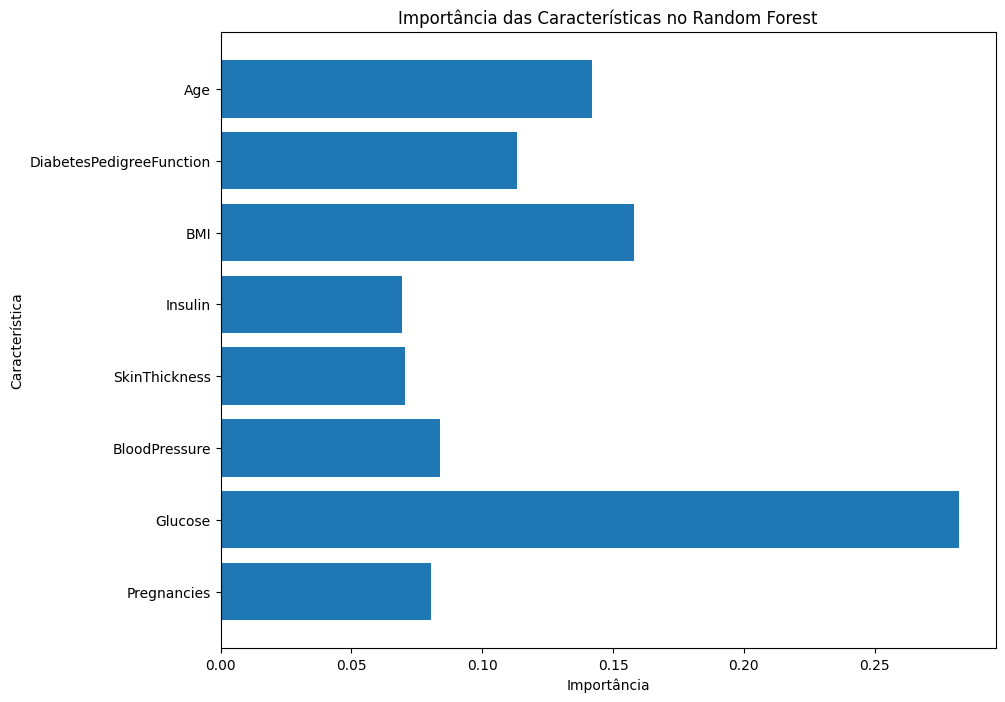

In [ ]:
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model, rf_accuracy, rf_cv_score = train_and_evaluate(random_forest_model, X_train, X_test, y_train, y_test)
plt.figure(figsize=(10, 8))
plt.barh(feature_columns, rf_model.feature_importances_)
plt.xlabel("Importância")
plt.ylabel("Característica")
plt.title("Importância das Características no Random Forest")
plt.show()


In [ ]:
print(f"Random Forest - Acurácia: {rf_accuracy:.2f}, CV Score: {rf_cv_score:.2f}")

Random Forest - Acurácia: 0.75, CV Score: 0.77


### Treinamento e Avaliação dos Modelos
Cada modelo é treinado e avaliado usando uma divisão de treino e teste dos dados, e a validação cruzada é usada para garantir a robustez dos resultados.


In [ ]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=500)  # Aumentando o número de iterações
}

def repeated_training_evaluation(model, X_train, X_test, y_train, y_test, n=100):
    accuracies = []
    cv_scores = []
    for _ in range(n):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
        accuracies.append(accuracy)
        cv_scores.append(cv_score)
    return np.mean(accuracies), np.mean(cv_scores)

# Escalando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Usando a função para treinar e avaliar os modelos 100 vezes
extended_results = {}
for name, model in models.items():
    if name == 'Logistic Regression':
        mean_accuracy, mean_cv_score = repeated_training_evaluation(model, X_train_scaled, X_test_scaled, y_train, y_test)
    else:
        mean_accuracy, mean_cv_score = repeated_training_evaluation(model, X_train, X_test, y_train, y_test)
    extended_results[name] = (mean_accuracy, mean_cv_score)

# Exibindo os resultados estendidos
for model_name, (mean_accuracy, mean_cv_score) in extended_results.items():
    print(f"{model_name} - Mean Accuracy: {mean_accuracy:.2f}, Mean CV Score: {mean_cv_score:.2f}")

Random Forest - Mean Accuracy: 0.75, Mean CV Score: 0.77
Decision Tree - Mean Accuracy: 0.70, Mean CV Score: 0.71
Logistic Regression - Mean Accuracy: 0.74, Mean CV Score: 0.78


### Geração e Avaliação de Modelos com Parâmetros Variados
Nesta seção, geraremos várias configurações para cada um dos três modelos selecionados, visando explorar como diferentes ajustes de parâmetros podem influenciar o desempenho dos modelos. Serão treinados um total de 90 modelos, divididos em 15 configurações distintas para cada uma das três técnicas de IA.


In [ ]:
# Definição dos grids de parâmetros para garantir 15 combinações
param_grid_decision_tree = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10],
    'criterion': ['gini', 'entropy']
}

param_grid_logistic_regression = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

param_grid_random_forest = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20]
}

# Função para criar e avaliar modelos variados
def create_and_evaluate_models(model_class, param_grid, X_train, X_test, y_train, y_test, repeats=2):
    results = []
    grid = list(ParameterGrid(param_grid))
    for params in grid[:15]:  # Assegura 15 configurações
        for _ in range(repeats):  # Repete cada configuração duas vezes
            model = model_class(**params)
            try:
                model.fit(X_train, y_train)
                accuracy = model.score(X_test, y_test)
                cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))
                results.append({'Parâmetros': params, 'Acurácia': accuracy, 'CV Score Médio': cv_score})
            except Exception as e:
                print(f"Erro ao treinar o modelo com parâmetros {params}: {e}")
    return results

# Escalando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criando e avaliando os modelos
all_results = []
all_results.extend(create_and_evaluate_models(DecisionTreeClassifier, param_grid_decision_tree, X_train, X_test, y_train, y_test))
all_results.extend(create_and_evaluate_models(LogisticRegression, param_grid_logistic_regression, X_train_scaled, X_test_scaled, y_train, y_test))
all_results.extend(create_and_evaluate_models(RandomForestClassifier, param_grid_random_forest, X_train, X_test, y_train, y_test))

# Convertendo os resultados para um DataFrame para exibição em tabela
results_df = pd.DataFrame(all_results)
results_df

# Exibindo a tabela formatada
results_df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
)

,Parâmetros,Acurácia,CV Score Médio
0,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}",0.701299,0.705729
1,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}",0.714286,0.714988
2,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}",0.709957,0.726255
3,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}",0.709957,0.715126
4,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}",0.688312,0.702008
5,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}",0.705628,0.690879
6,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}",0.718615,0.730010
7,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}",0.718615,0.726237
8,"{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2}",0.709957,0.698356
9,"{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2}",0.705628,0.713223


## Análise da Matriz de Confusão para Modelos de Classificação
Esta seção apresenta a matriz de confusão para cada modelo de classificação utilizado. A matriz de confusão ajuda a visualizar o desempenho do modelo em termos de previsões corretas e incorretas, fornecendo insights sobre as verdadeiras positivas, falsas positivas, verdadeiras negativas e falsas negativas.

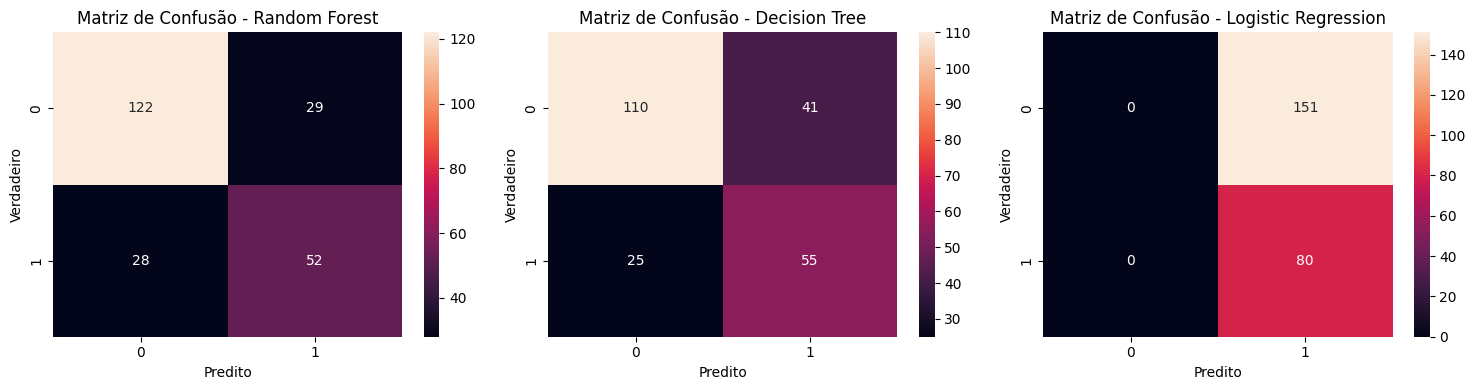

In [ ]:
# Define o número de modelos para determinar quantos subplots serão necessários
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(n_models * 5, 4))  # Ajuste o tamanho conforme necessário

if n_models == 1:
    axes = [axes]  # Garante que 'axes' seja iterável mesmo com um único modelo

# Iterando sobre cada modelo para plotar suas respectivas matrizes de confusão
for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax)
    ax.set_title(f'Matriz de Confusão - {name}')
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

## Comparativo de Desempenho via Curva ROC e AUC
Aqui, analisamos a Curva de Característica Operacional do Receptor (ROC) e a Área Sob a Curva (AUC) para cada modelo. Estes gráficos são cruciais para avaliar a capacidade dos modelos de discriminar entre as classes. Um valor de AUC mais alto indica um melhor desempenho do modelo na classificação das categorias.

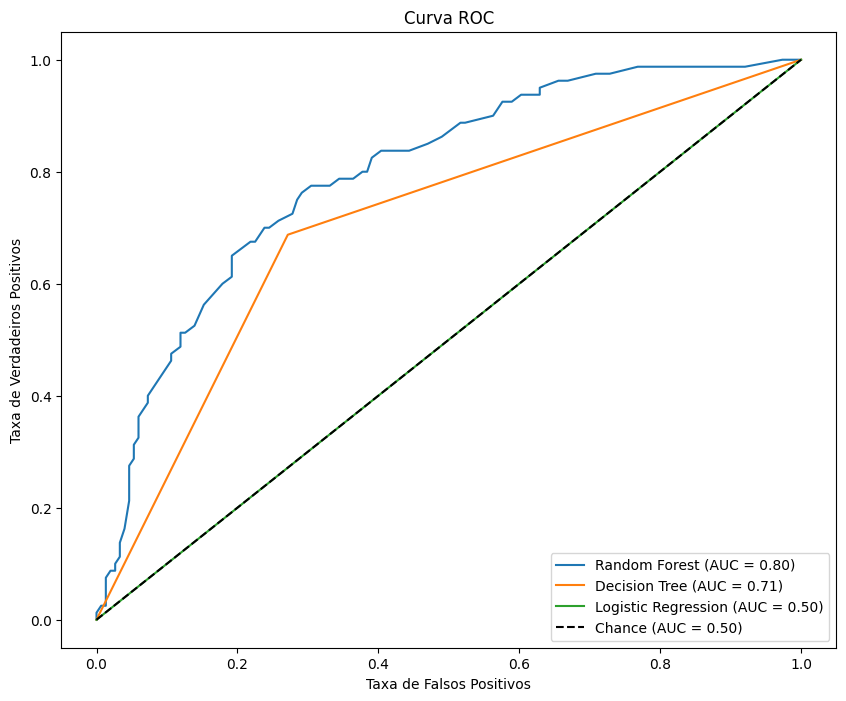

In [ ]:
# Plotando a curva ROC para cada modelo
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## Avaliação de Overfitting Através de Validação Cruzada
Exploramos o potencial de overfitting dos modelos por meio de validação cruzada, utilizando diferentes partições dos dados. Esta análise ajuda a entender como os modelos se comportam em diferentes amostras dos dados, indicando sua capacidade de generalização e robustez.

In [ ]:
# Preparando uma lista para armazenar os resultados
results = []

# Avaliando o desempenho com validação cruzada para cada modelo
for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5)
    results.append({
        'Modelo': name,
        'Scores de CV': cv_scores,
        'Média dos Scores': np.mean(cv_scores),
        'Desvio Padrão': np.std(cv_scores)
    })

# Criando um DataFrame para exibir os resultados
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Modelo')  # Definindo 'Modelo' como índice para melhor visualização
print(results_df)

                                                          Scores de CV  \
Modelo                                                                   
Random Forest        [0.7467532467532467, 0.7207792207792207, 0.779...   
Decision Tree        [0.6688311688311688, 0.6753246753246753, 0.688...   
Logistic Regression  [0.7727272727272727, 0.7467532467532467, 0.753...   

                     Média dos Scores  Desvio Padrão  
Modelo                                                
Random Forest                0.765691       0.034527  
Decision Tree                0.701918       0.034755  
Logistic Regression          0.772193       0.022369  
